In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as tx
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_recall_curve

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

df_complete = pd.read_csv('gutenberg/cleansed_combined.csv')

## 1 - Die zehn häufigsten Adjektiv-Nomen-Bigramme

In [3]:
df_complete = df_complete.sort_values(by=['document_id', 'ta_offset'])
df_complete = df_complete.reset_index(drop=True)


df_complete2 = df_complete.copy(deep=True)
df_complete2.index -= 1

bigramms = df_complete.join(df_complete2, on=df_complete.index, how='inner', rsuffix='_2')
bigramms = bigramms[(bigramms.ta_type == 'adjective') & (bigramms.ta_type_2 == 'noun')][['document_id', 'ta_sentence', 'ta_normalized', 'ta_token_2']]
bigramms.columns = ['document_id', 'ta_sentence', 'adjective', 'noun']

bigramms.groupby(by=['adjective', 'noun'], as_index=False).document_id.count().sort_values(by='document_id', ascending=False).head(10)

,adjective,noun,document_id
79094,inneren,Sinn,167
40126,ersten,Male,101
88611,kurzer,Zeit,82
89257,lange,Zeit,80
50588,ganzen,Tag,79
8079,andern,Seite,77
50065,ganze,Welt,73
88422,kurze,Zeit,71
100291,naechsten,Morgen,71
62294,gleicher,Zeit,67


## 2 - Die zehn häufigsten Adjektiv-Co-Occurrences

In [4]:
adjDf = df_complete[df_complete.ta_type == 'adjective'][['document_id', 'ta_sentence', 'ta_normalized']].groupby(by=['document_id', 'ta_sentence'])['ta_normalized'].apply(list).reset_index(name='co_occurrences')
adjDf = adjDf[adjDf.co_occurrences.str.len() > 1]

adjDf['co_occurrences'] = adjDf['co_occurrences'].apply(lambda x: [(a, b) for idx, a in enumerate(x) for b in x[idx + 1:]])
adjDf = adjDf.explode('co_occurrences')
adjDf['co_occurrences'] = adjDf['co_occurrences'].apply(lambda otuple: min(otuple) + ', ' + max(otuple))

occurrence_counts = adjDf[['co_occurrences']].groupby(by='co_occurrences', as_index=False).size().sort_values(by='size', ascending=False)
occurrence_counts.head(10)

,co_occurrences,size
18362,"aeusseren, inneren",181
43130,"andere, eine",133
36816,"alten, neuen",109
42508,"andere, andere",98
392817,"grossen, kleinen",98
389792,"grosse, grossen",93
172290,"deutschen, deutschen",89
33598,"alte, neue",84
17522,"aeussere, innere",79
258188,"ersten, zweiten",77


## 3 - Wörter mit den Top-3 TF-IDF Werten

In [26]:
stats_df = pd.read_csv('gutenberg/cleansed_summarized.csv')
# docs = stats_df[stats_df.genre == 'Geschichte'].index.to_list()
docs = stats_df[stats_df.genre != 'blabla'].index.to_list()

df_nouns = df_complete[df_complete.document_id.isin(docs) & (df_complete.ta_type == 'noun')]
df_nouns = df_nouns[['document_id', 'ta_normalized']].groupby(by=['document_id', 'ta_normalized'], as_index=False).size()

vector_df = df_nouns.pivot(index='document_id', columns='ta_normalized', values='size').fillna(0)
vector = vector_df.to_numpy()

tfidf_transformer = tx.TfidfTransformer(smooth_idf=False, use_idf=True, sublinear_tf=False, norm=None)
tfidf_transformer.fit(vector)

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vector_df.columns, columns=["idf_weights"]).sort_values(by=['idf_weights'])

tf_idf_vector = tfidf_transformer.transform(vector)

tf_idf_df = pd.DataFrame(tf_idf_vector.T.todense(), index=vector_df.columns, columns=vector_df.index.to_list())


In [27]:
top_tfidf = tf_idf_df.max(axis=1).sort_values(ascending=False).head(3).to_frame()
top_tfidf.columns = ['tf_idf']
top_tfidf

,tf_idf
ta_normalized,
moreau,1633.544923
buddha,1545.327639
pjotr,1452.841732


## 4 - Ähnlichkeitsanfragen

In [28]:
vector_df_transposed = vector_df.transpose()

###  Ähnlichkeit zu Dokument 0

**a) Skalarprodukt**

In [29]:
dotted = vector_df.dot(vector_df_transposed[0]).sort_values(ascending=False)
dotted.to_frame().join(stats_df[['title', 'author']], how='left').head(10)

,0,title,author
document_id,,,
389,916.0,Über das Erste Buch Mose. 1. Kapitel bis 9. Ka...,"Swedenborg, Emanuel von"
1171,868.0,Die Große Französische Revolution 1789-1793 - ...,"Kropotkin, Pjotr Alexejewitsch"
929,827.0,Ludwig Tieck,"Köpke, Rudolf"
319,765.0,Aus der Triumphgasse,"Huch, Ricarda"
1103,739.0,Über das Universum. Anonyme Mitschrift der Kos...,"Humboldt, Alexander von"
390,687.0,Die Apostel,"Renan, Ernest"
822,592.0,Eine Kindheit,"Marti, Hugo"
274,522.0,Was ist Wahrheit,"Wieland, Christoph Martin"
844,491.0,Zur Genealogie der Moral,"Nietzsche, Friedrich Wilhelm"


**b) Kosinus-Ähnlichkeit**

In [30]:
transformer = Normalizer().fit(vector)
normalized = transformer.transform(vector)

vector_df_norm = pd.DataFrame(data=normalized, index=vector_df.index, columns=vector_df.columns)
vector_df_norm_transposed = vector_df_norm.transpose()

cosine = vector_df_norm.dot(vector_df_norm_transposed[0]).sort_values(ascending=False)
cosine.to_frame().join(stats_df[['title', 'author']], how='left').head(10)

,0,title,author
document_id,,,
0,1.000000,Vom Einfluß der Theorie,"Ranke, Leopold von"
1,0.312446,Über die Verwandtschaft und den Unterschied de...,"Ranke, Leopold von"
378,0.250323,... ganz anders,"Tucholsky, Kurt"
1175,0.247700,Politische Schriften des Jahres 1809,"Kleist, Heinrich von"
5,0.216614,Frankreich und Deutschland,"Ranke, Leopold von"
207,0.198680,Hatha-Yoga - die indische Fakir-Lehre zur Entw...,"Wilke, Max"
1109,0.197955,Handbüchlein für Wühler,"Hoffmann, Heinrich"
1133,0.195815,Englische Fragmente,"Heine, Heinrich"
1176,0.193648,Vorläufer des neueren Sozialismus. Dritter Band,"Kautsky, Karl"


## 5 - Ähnlichste Dokumente

### Kosinus-Ähnlichkeit zu Text 10

In [31]:
cosine = vector_df_norm.dot(vector_df_norm_transposed[10]).sort_values(ascending=False)
cosine.to_frame().join(stats_df[['title', 'author']], how='left').head(10)

,0,title,author
document_id,,,
10,1.000000,"Römische Geschichte, Buch 4","Mommsen, Theodor"
11,0.494864,"Römische Geschichte, Buch 3","Mommsen, Theodor"
29,0.392140,Sittengeschichte Roms,"Friedlaender, Ludwig"
9,0.370945,"Römische Geschichte, Buch 5","Mommsen, Theodor"
24,0.342265,Verfall und Untergang des Römischen Reiches. B...,"Gibbon, Edward"
12,0.305786,"Römische Geschichte, Buch 2","Mommsen, Theodor"
19,0.301707,Geschichte der Stadt Rom im Mittelalter,"Gregorovius, Ferdinand"
1045,0.296907,Franzosen,"Hofmiller, Josef"
21,0.286062,Verfall und Untergang des Römischen Reiches. B...,"Gibbon, Edward"


### Kosinus-Ähnlichkeit zu Text 100

In [32]:
cosine = vector_df_norm.dot(vector_df_norm_transposed[4]).sort_values(ascending=False)
cosine.to_frame().join(stats_df[['title', 'author']], how='left').head(10)

,0,title,author
document_id,,,
4,1.000000,Geschichte und Philosophie,"Ranke, Leopold von"
1,0.321165,Über die Verwandtschaft und den Unterschied de...,"Ranke, Leopold von"
744,0.321123,Der Aufgang des Abendlandes,"Bleibtreu, Karl"
846,0.259625,So war mein Wien,"Groner, Auguste"
232,0.248354,Mozart auf der Reise nach Prag,"Mörike, Eduard"
8,0.208808,Weltgeschichtliche Betrachtungen,"Burckhardt, Jacob"
844,0.203928,Zur Genealogie der Moral,"Nietzsche, Friedrich Wilhelm"
843,0.201227,Bismarck,"Ludwig, Emil"
1184,0.193086,Selbstbiographie,"Grillparzer, Franz"


# II. Evaluation

## 1 - Precision-Recall Plot für Themengebiet "Antike"

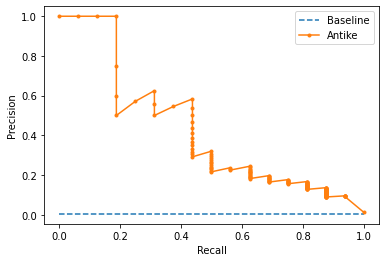

In [33]:
titles = [
    "Das Kulturleben der Griechen und Römer in seiner Entwicklung",
    "Römische Charakterköpfe",
    "Alexander der Große und das Weltgriechentum",
    "Charakterbilder Spätroms und die Entstehung des modernen Europa",
    "Zur Kulturgeschichte Roms",
    "Frauen der Antike",
    "Die Zeit Constantins des Großen",
    "Sechs Bücher vom Staat",
    "Geschichte der Völkerwanderung. Band I",
    "Geschichte der Völkerwanderung. Band II",
    "Sittengeschichte Roms",
    "Verfall und Untergang des Römischen Reiches. Band I",
    "Verfall und Untergang des Römischen Reiches. Band II",
    "Verfall und Untergang des Römischen Reiches. Band III",
    "Verfall und Untergang des Römischen Reiches. Band IV",
    "Athenaïs",
    "Der Kaiser Hadrian",
    "Geschichte der Stadt Athen im Mittelalter",
    "Geschichte der Stadt Rom im Mittelalter",
    "Politische Betrachtungen über die alte und die italienische Geschichte",
    "Das Römische Imperium der Cäsaren",
    "Römische Geschichte, Buch 1",
    "Römische Geschichte, Buch 2",
    "Römische Geschichte, Buch 3",
    "Römische Geschichte, Buch 4",
    "Römische Geschichte, Buch 5",
    "Römische Geschichte, Buch 8",
    "Die Gesetzgebung des Lykurgus und Solon",
    "Ithaka der Peloponnes und Troja",
    "Kaiserbiographien",
    "Die Germania",
    "Römische Geschichte",
    "Anabasis (Deutsche Fassung)"
]

relevant_ids = stats_df[stats_df.title.isin(titles)].index.to_list()

basic_vector = vector_df_transposed.index.to_frame().drop(['ta_normalized'], axis=1)
basic_vector['val'] = 0

advanced_vector = basic_vector.copy(deep=True)

basic_keywords = ['rom', 'athen', 'griechenland']
keywords = []

basic_vector.loc[basic_keywords] = 1
advanced_vector.loc[keywords] = 1

cosine_prediction = vector_df_norm.dot(basic_vector['val'])

labels = cosine_prediction.copy(deep=True)
labels = cosine_prediction.index.to_frame().drop(['document_id'], axis=1)
labels['val'] = 0
labels.loc[relevant_ids] = 1

precision, recall, thresholds = precision_recall_curve(labels.to_numpy(), cosine_prediction.to_numpy())

baseline = 5 / len(labels)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot(recall, precision, marker='.', label='Antike')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()